In [1]:
!pip install statsmodels --upgrade
!pip install openpyxl

In [2]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

#Importing library for date manipulation
from datetime import datetime

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

#Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

#To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [5]:
# Setting date as the index
df = df.set_index(['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


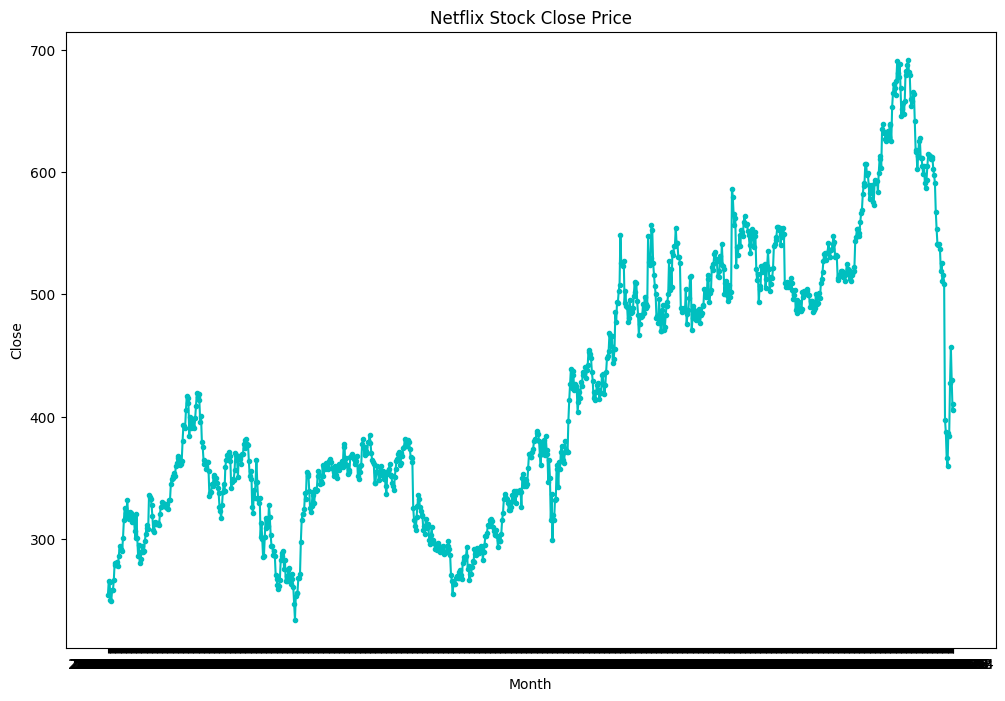

In [6]:
plt.figure(figsize = (12,8))
plt.xlabel('Month')
plt.ylabel('Close')
plt.title('Netflix Stock Close Price')
plt.plot(df.index, df.Close, color = 'c', marker = '.')


In [7]:
data = df['Close']
data.head()

Date
2018-02-05    254.259995
2018-02-06    265.720001
2018-02-07    264.559998
2018-02-08    250.100006
2018-02-09    249.470001
Name: Close, dtype: float64

In [8]:
df_train = data.loc['2018-02-05':'2021-02-05']
df_test = data.loc['2021-02-06' : '2022-02-05']
print(df_train)
print(df_test)

Date
2018-02-05    254.259995
2018-02-06    265.720001
2018-02-07    264.559998
2018-02-08    250.100006
2018-02-09    249.470001
                 ...    
2021-02-01    539.039978
2021-02-02    548.159973
2021-02-03    539.450012
2021-02-04    552.159973
2021-02-05    550.789978
Name: Close, Length: 757, dtype: float64
Date
2021-02-08    547.919983
2021-02-09    559.070007
2021-02-10    563.590027
2021-02-11    557.590027
2021-02-12    556.520020
                 ...    
2022-01-31    427.140015
2022-02-01    457.130005
2022-02-02    429.480011
2022-02-03    405.600006
2022-02-04    410.170013
Name: Close, Length: 252, dtype: float64


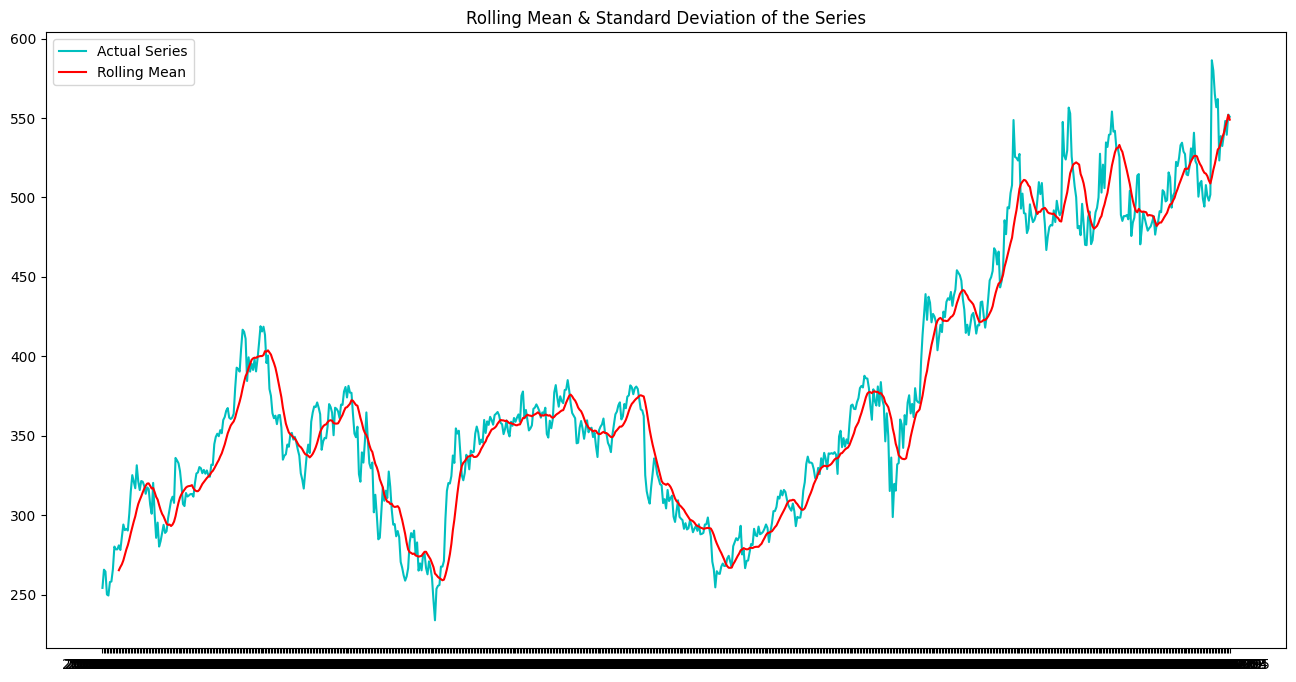

In [9]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean')
#rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

We can also use the Augmented Dickey-Fuller (ADF) Test to verify if the series is stationary or not. The null and alternate hypotheses for the ADF Test are defined as:

Null hypothesis: The Time Series is non-stationary
Alternative hypothesis: The Time Series is stationary

In [10]:
#Define a function to use adfuller test
def adfuller(df_train):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df_train)
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic           -0.571437
p-value                   0.877306
Lags Used                15.000000
No. of Observations     741.000000
Critical Value (1%)      -3.439206
Critical Value (5%)      -2.865448
Critical Value (10%)     -2.568851
dtype: float64


Making the series stationary¶
We can use some of the following methods to convert a non-stationary series into a stationary one:

1. Log Transformation
2. By differencing the series (lagged series)
Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

From the above test, we can see that the p-value = 1 i.e. > 0.05 (For 95% confidence intervals) therefore, we fail to reject the null hypothesis.
Hence, we can confirm that the series is non-stationary.

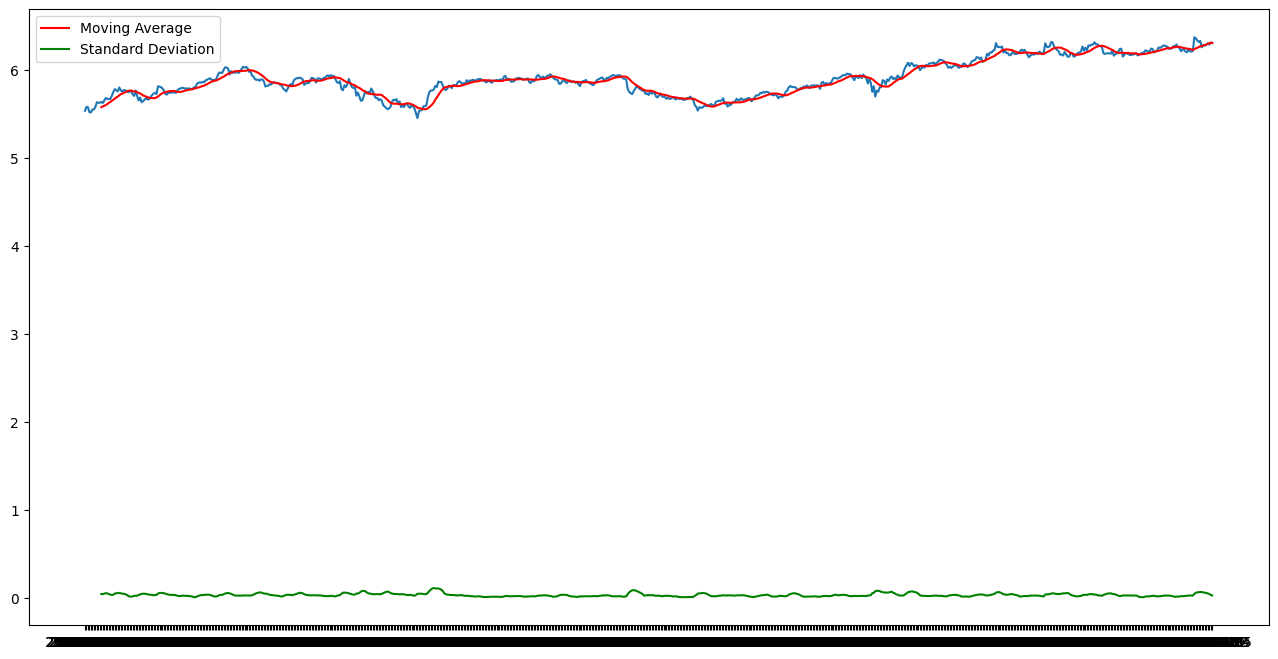

In [11]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

Observations:

Since we can still see the upward trend in the series, we can conclude that the series is still non-stationary.
However, the standard deviation is almost constant which implies that now the series has constant variance.
Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series)

and then check the rolling mean and standard deviation.

Visualizing the rolling mean and rolling standard deviation of the shifted series (df_shift) and checking the stationarity by calling the adfuller() function

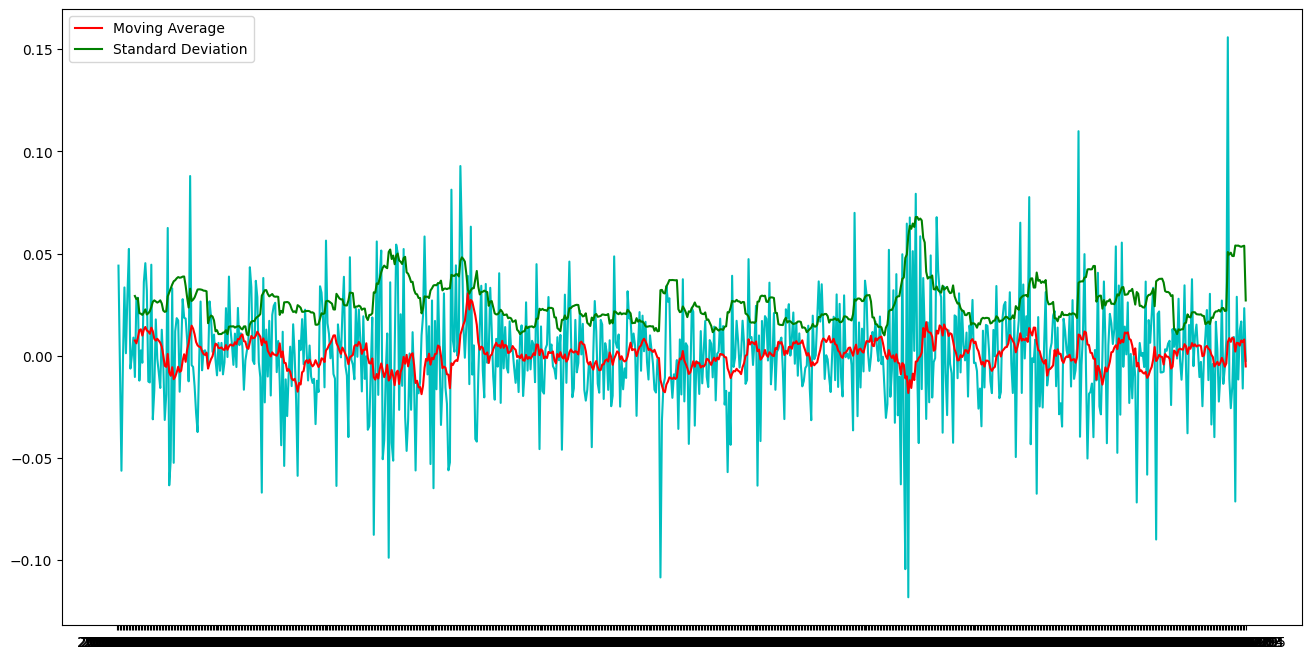

In [12]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

Observations:

The mean and the standard deviation seem to be constant over time.
Let us use the adfuller test to check the stationarity.

In [13]:
adfuller(df_shift)


Dickey-Fuller Test: 
Test Statistic         -1.130971e+01
p-value                 1.247723e-20
Lags Used               7.000000e+00
No. of Observations     7.480000e+02
Critical Value (1%)    -3.439123e+00
Critical Value (5%)    -2.865412e+00
Critical Value (10%)   -2.568832e+00
dtype: float64


Observations:

We can see that the p-value is now far lesser than 0.05 (for 95% confidence interval), therefore we can reject the null hypothesis that the series is non-stationary.
We can conclude that the series is now stationary.
Let's decompose the time series to check its different components.

Decomposing the time series components into Trend, Seasonality and Residual¶


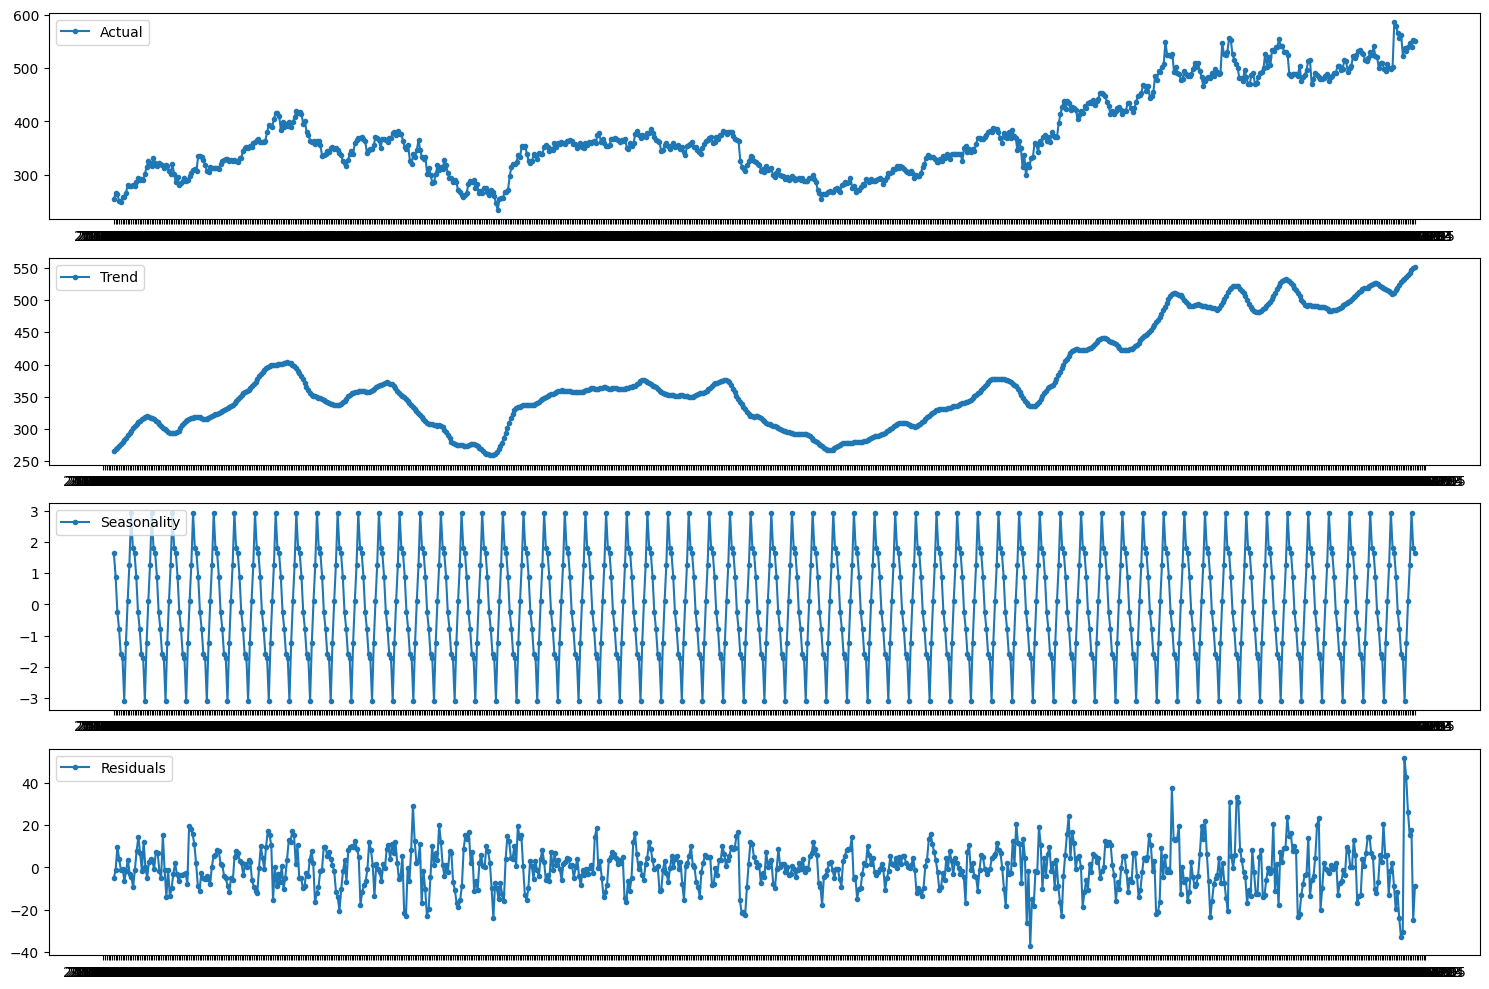

In [14]:
#Importing the seasonal_decompose to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_train, period = 12)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(df_train, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

Now let's move on to the model building section. First, we will plot the ACF and PACF plots to get the values of p and q i.e. order of AR and MA models to be used.

Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models

<Figure size 1600x800 with 0 Axes>

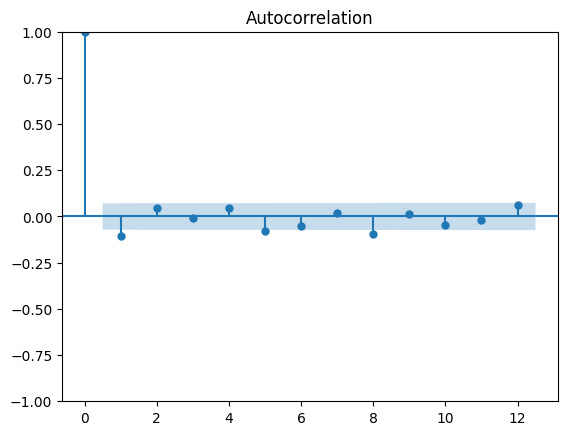

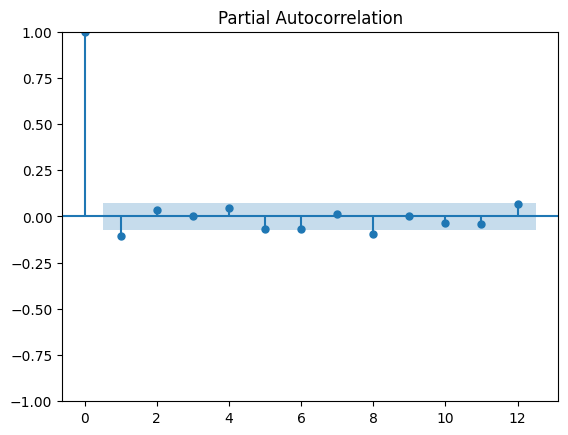

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12)
plt.show()
plot_pacf(df_shift, lags = 12)
plt.show()

Observations:

From the above PACF plot we can see that the highest lag at which the plot extends beyond the statistically significant boundary is lag 1.
This indicates that an AR Model of lag 1 (p=1) should be sufficient to fit the data.
Similarly, from the ACF plot, we can infer that q=1.




AR Model

Fitting and predict the shifted series with the AR Model and calculate the RMSE.

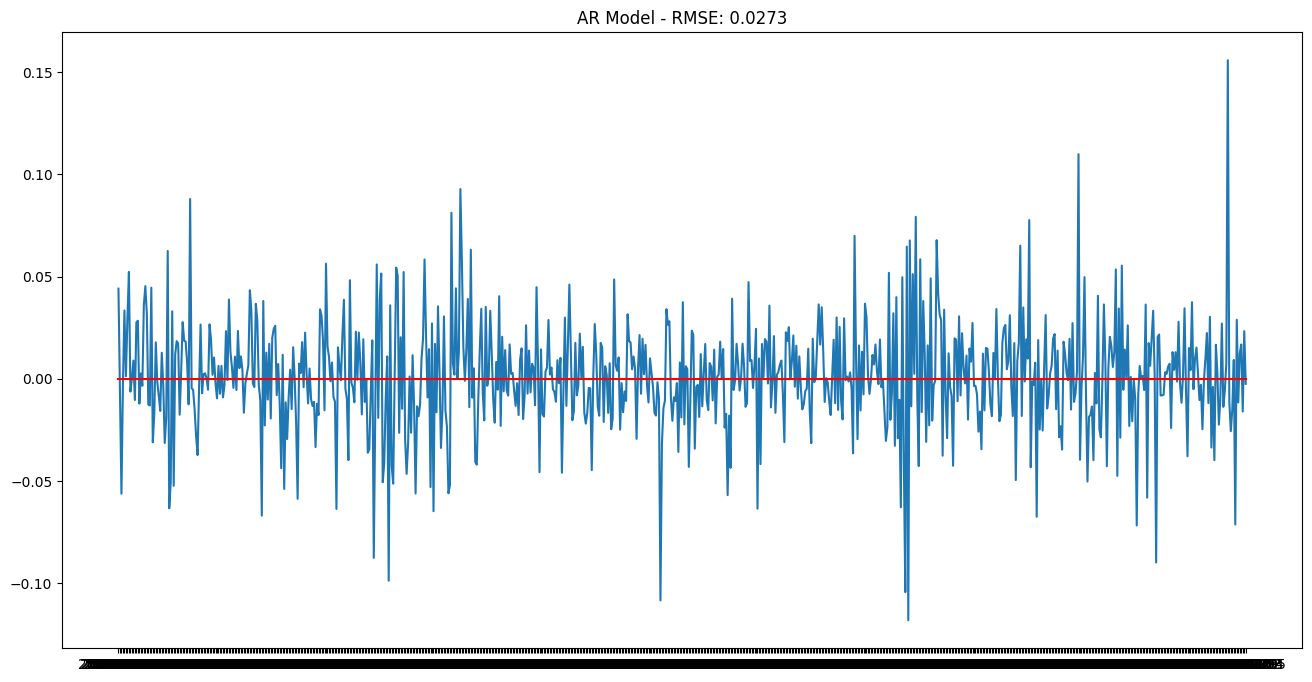

In [16]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=1) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict(start=0,end=len(df_shift)-1) #predict the series
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift, squared=False))  #Calculating rmse
plt.show()

We can see that by using the AR model, we get root mean squared error (RMSE) = 0.0273

Let's check the AIC value of the model




In [17]:
results_AR.aic


-3301.998969587512

MA Model

We will be using an ARIMA model with p=0 and d=0 so that it will work as an MA model

Fitting and predict the shifted series with the MA Model and calculate the RMSE

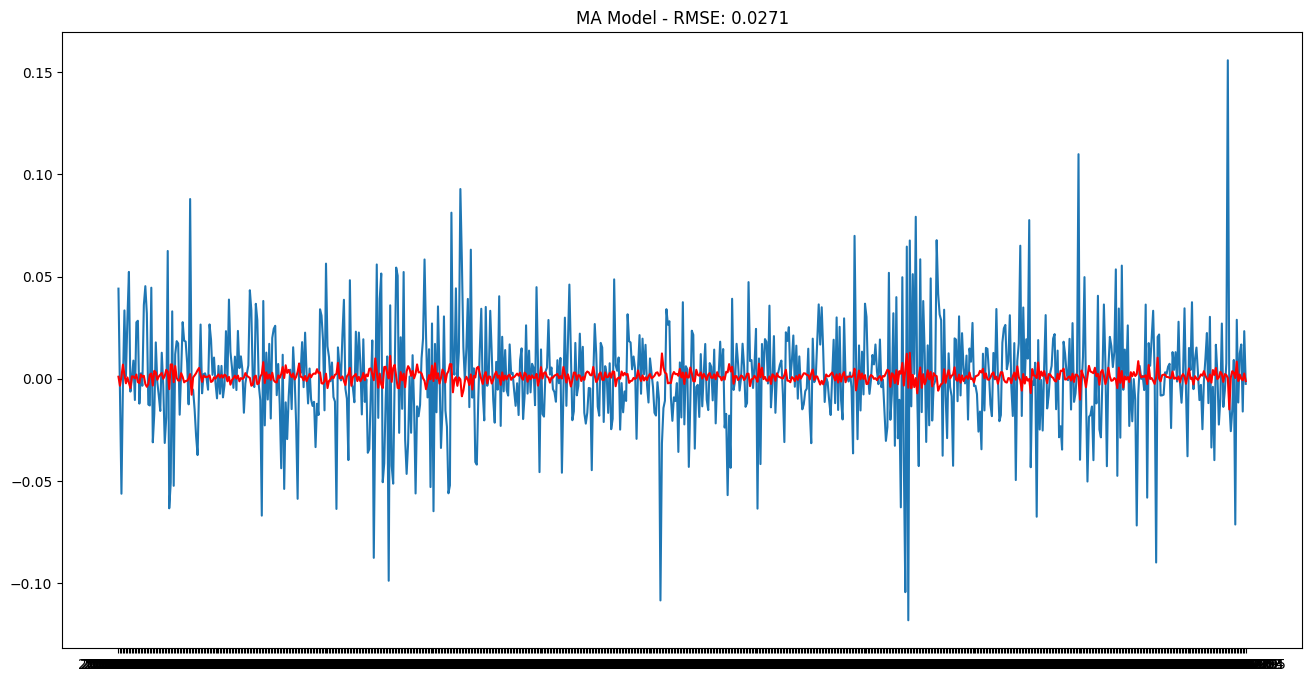

In [18]:
from statsmodels.tsa.arima.model import ARIMA
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0, 0, 1)) #Using p=0, d=0, q=1 and apply arima function on df_shift series
results_MA = model_MA.fit()
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift , squared=False))
plt.show()

The MA model is giving a slightly higher(by 0.0002) RMSE when compared to the AR model.


In [19]:
results_MA.aic


-3304.165576209725

ARMA Model

We will be using an ARIMA model with p=1 and q=1 (as observed from the ACF and PACF plots) and d=0 so that it will work as an ARMA mode

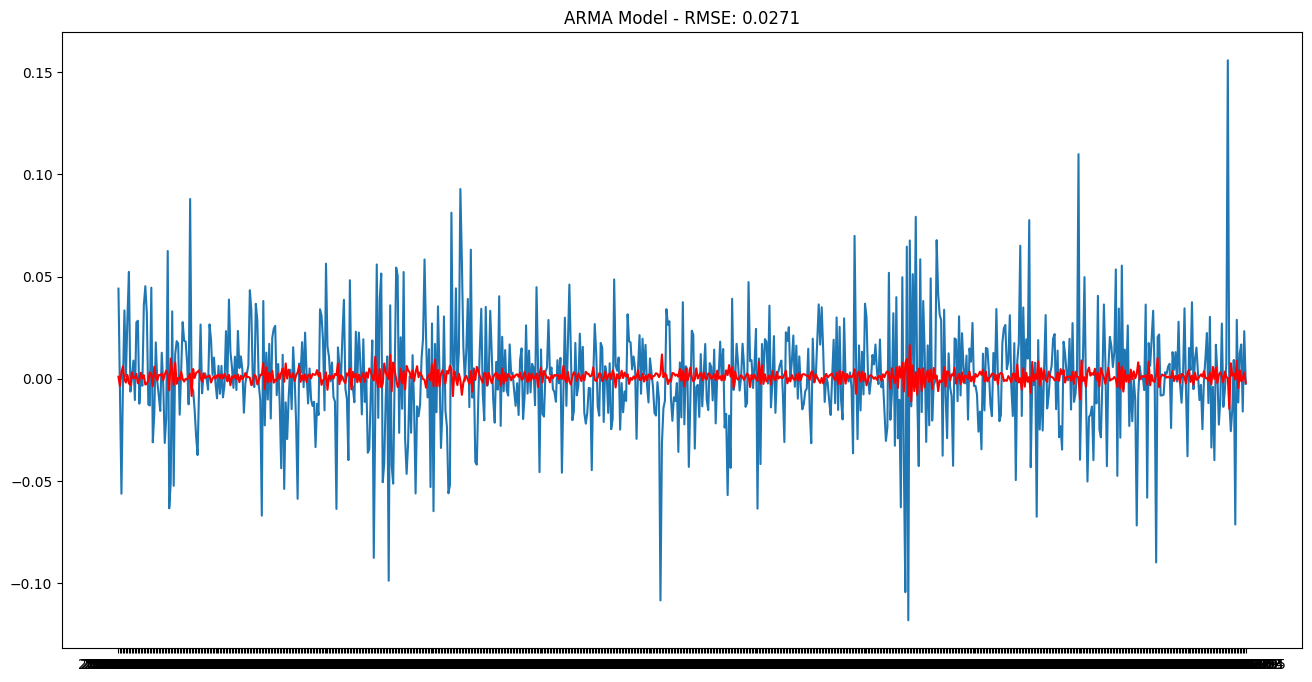

In [20]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(1, 0, 1)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA = model_ARMA.fit()
plt.plot(df_shift)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift , squared=False))
plt.show()

In [21]:
results_ARMA.aic


-3304.0780654100445

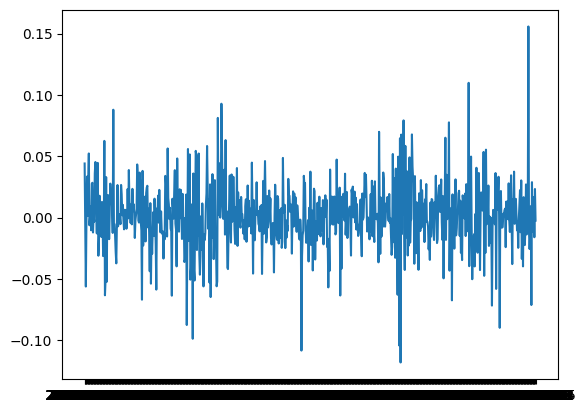

In [22]:
plt.plot(df_shift)

ARIMA Model

We will be using an ARIMA Model with p=1, d=1, & q=1.

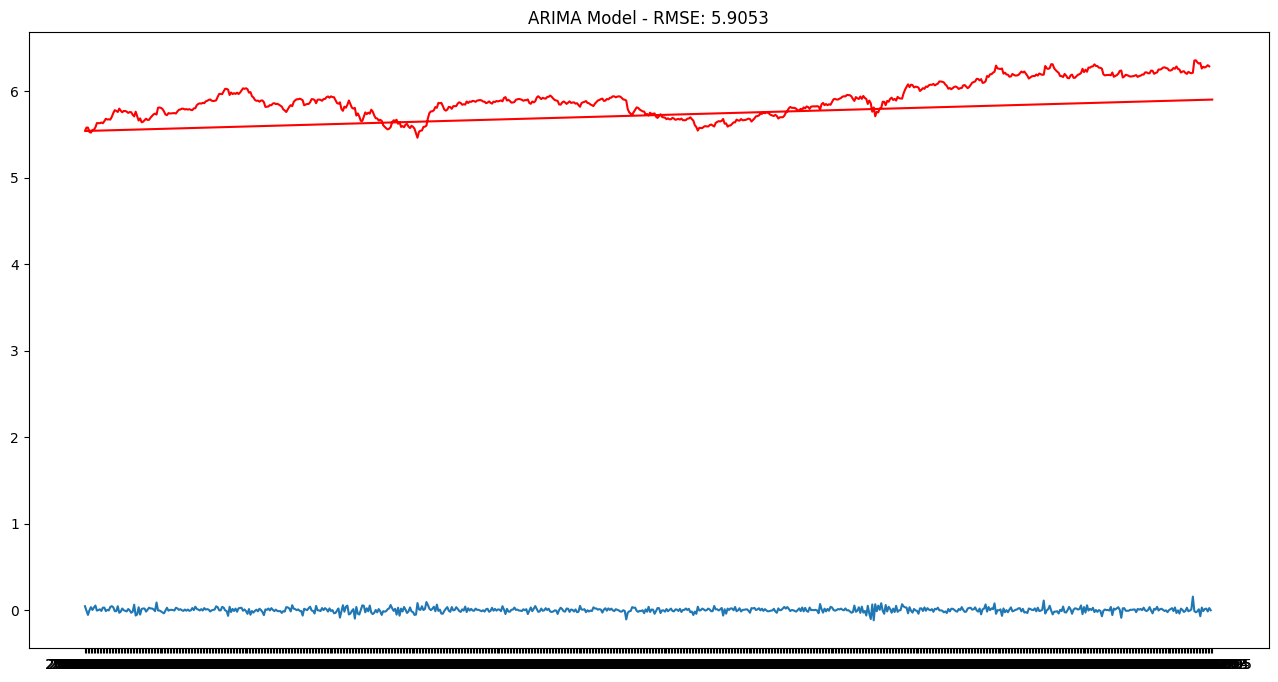

In [25]:
plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log, order=(1,0,1))  #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit()\

l = min(len(df_shift), len(results_ARIMA.fittedvalues))

results_ARIMA_trimmed = results_ARIMA.fittedvalues[:l]
df_shift = df_shift[:l]

plt.plot(df_shift)
plt.plot(results_ARIMA_trimmed, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA_trimmed, df_shift, squared=False))
plt.show()

In [26]:
# Printing the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
predictions

Date
2018-02-05    5.904567
2018-02-06    5.541186
2018-02-07    5.580732
2018-02-08    5.580377
2018-02-09    5.529643
                ...   
2021-02-01    6.275649
2021-02-02    6.286057
2021-02-03    6.302145
2021-02-04    6.289171
2021-02-05    6.308989
Length: 757, dtype: float64

In [24]:
results_ARIMA.aic


-3304.847537593754

In [27]:
#First step - doing cumulative sum
predictions_cumsum = predictions.cumsum() # use .cumsum fuction on the predictions
predictions_cumsum

Date
2018-02-05       5.904567
2018-02-06      11.445753
2018-02-07      17.026485
2018-02-08      22.606862
2018-02-09      28.136505
                 ...     
2021-02-01    4443.639606
2021-02-02    4449.925663
2021-02-03    4456.227808
2021-02-04    4462.516979
2021-02-05    4468.825968
Length: 757, dtype: float64

In [29]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log

Date
2018-02-05      11.442925
2018-02-06      16.984110
2018-02-07      22.564842
2018-02-08      28.145219
2018-02-09      33.674863
                 ...     
2021-02-01    4449.177963
2021-02-02    4455.464020
2021-02-03    4461.766165
2021-02-04    4468.055336
2021-02-05    4474.364325
Length: 757, dtype: float64

In [31]:
#Third step - applying exponential transformation
predictions_ARIMA = np.exp(predictions_log) #use exponential function
predictions_ARIMA

Date
2018-02-05    9.323930e+04
2018-02-06    2.377418e+07
2018-02-07    6.306471e+09
2018-02-08    1.672297e+12
2018-02-09    4.215092e+14
                  ...     
2021-02-01             inf
2021-02-02             inf
2021-02-03             inf
2021-02-04             inf
2021-02-05             inf
Length: 757, dtype: float64

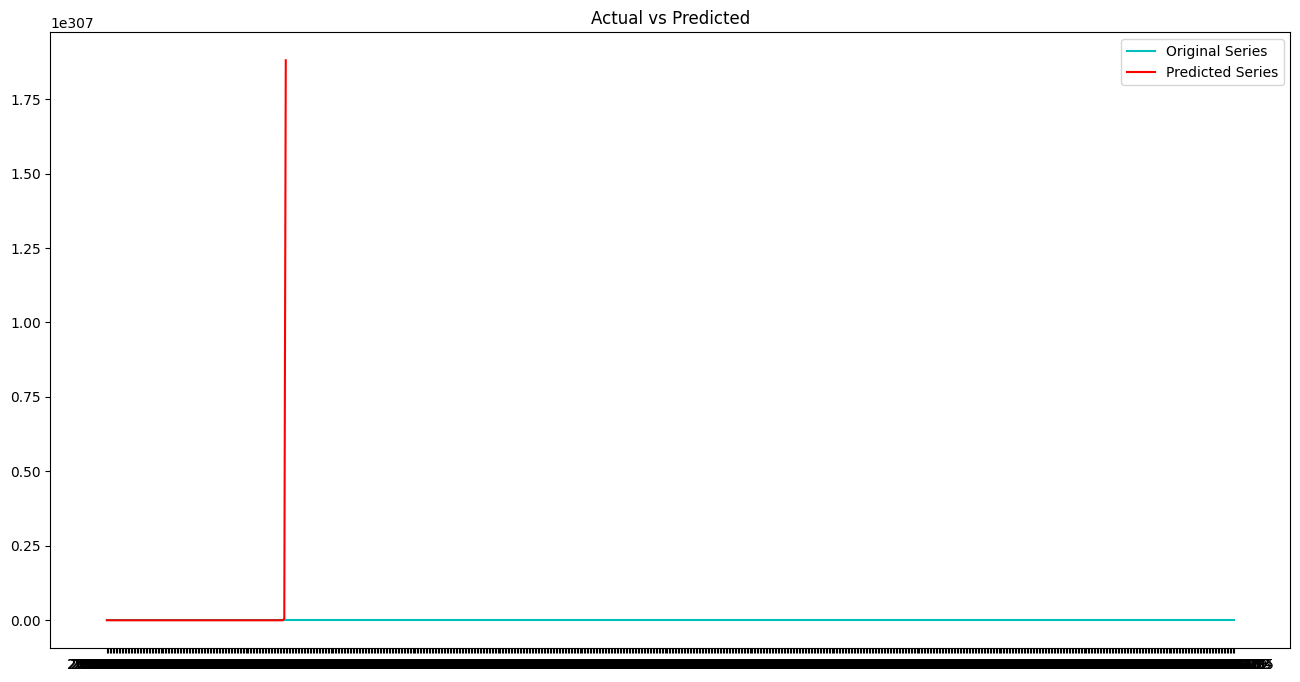

In [32]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions ARIMA
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [40]:
! pip install pmdarima

from pmdarima.arima import auto_arima

# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(data, seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7710.734, Time=2.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7707.609, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7706.977, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7707.056, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7705.806, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7707.853, Time=0.65 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.569 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1009
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3851.903
Date:                Sat, 08 Jun 2024   AIC                           7705.806
Time:                        17:14:02   BIC                           7710.722
Sample:                             0   HQIC                          7707.674
          

In [41]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()

    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = data.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

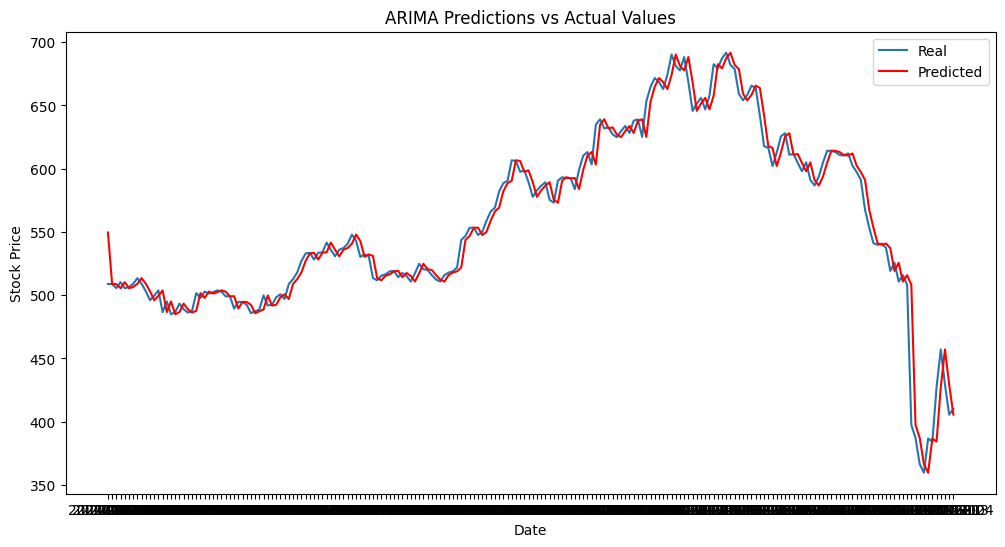

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(data[size:].index, test, label='Real')
plt.plot(data[size:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [46]:
# Calculate test metrics
mse = mean_squared_error(test, predictions)

print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 170.4587149219983


Using LSTM

In [48]:
training = int(np.ceil(len(data) * .95))
print(training)


959
1009


In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1,1))

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [54]:

import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime


model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7fabe878cd60>>

In [55]:

model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
29/29 [==============================] - 11s 15ms/step - loss: 0.0368
Epoch 2/10
29/29 [==============================] - 0s 12ms/step - loss: 0.0123
Epoch 3/10
29/29 [==============================] - 0s 13ms/step - loss: 0.0100
Epoch 4/10
29/29 [==============================] - 0s 12ms/step - loss: 0.0116
Epoch 5/10
29/29 [==============================] - 0s 12ms/step - loss: 0.0088
Epoch 6/10
29/29 [==============================] - 0s 12ms/step - loss: 0.0089
Epoch 7/10
29/29 [==============================] - 0s 12ms/step - loss: 0.0086
Epoch 8/10
29/29 [==============================] - 0s 11ms/step - loss: 0.0081
Epoch 9/10
29/29 [==============================] - 0s 11ms/step - loss: 0.0071
Epoch 10/10
29/29 [==============================] - 0s 12ms/step - loss: 0.0076


In [58]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = data.values[training:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2/2 [==============================] - 0s 11ms/step
MSE 12529.336253213054
RMSE 111.93451770215054


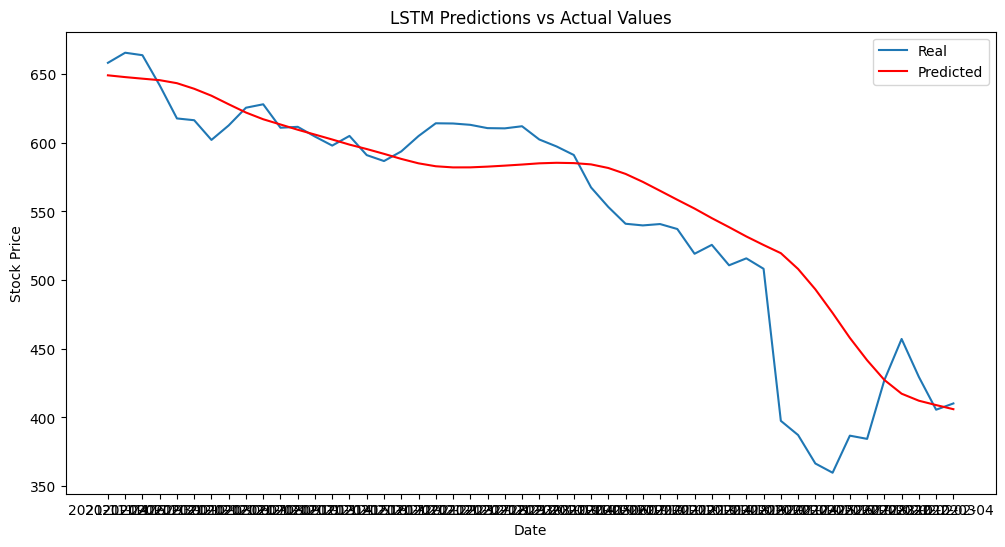

In [65]:
import matplotlib.pyplot as plt

test = data[training:]


plt.figure(figsize=(12, 6), dpi=100)
plt.plot(data[training:].index, test, label='Real')
plt.plot(data[training:].index, predictions, color='red', label='Predicted')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()